In [1]:
import sys
sys.path.insert(0,'C:\\Users\\Syahrir Ridha\\PycharmProjects\\NET_Solver\\')
import numpy as np
import pandas as pd
import torch
from geometry import *
from utils import Plot_Grid
from utils import *
from solver import *
from models import *
from mesh import *
from boundary import *
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 
%matplotlib inline

In [2]:
nx, ny = 8,8
X = torch.linspace(0,1, nx, requires_grad=True)
Y = torch.linspace(0,1, ny, requires_grad=True)
xx, yy = torch.meshgrid(X,Y)
data = torch.cat((yy.reshape(-1,1),xx.reshape(-1,1)),1)


def compute_grad(outputs, inputs):
    gradient, = torch.autograd.grad(outputs, inputs, grad_outputs=outputs.data.new(outputs.shape).fill_(1),
                                    create_graph=True, retain_graph=True, only_inputs=True)
    return gradient

class Trial_Solution:
    def __init__(self, model, boundary):
        self.model = model
        #self.model.apply(_init_weights)
        self.var = tuple(boundary.keys())
        self.bound = list(boundary.values())
        
    def __call__(self,input_data):
        #x = input_data[:,0].reshape(-1,1)
        trial = (input_data[:,0].reshape(-1,1) )*(1-input_data[:,0].reshape(-1,1))*self.model(input_data)
        return torch.abs_(trial)
net = MLP(2,1,1,1, act=torch.nn.Tanh())
trial = Trial_Solution(net, {'xi_inn':0.0, 'xi_out':1.0})


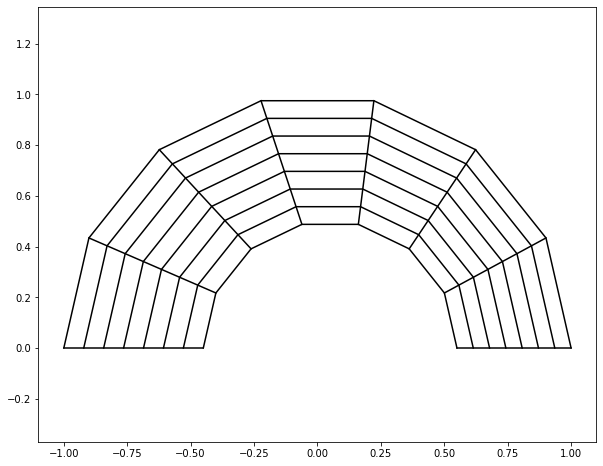

In [3]:
xi_, eta_ = torch.linspace(0,1,nx,requires_grad=True), torch.linspace(0,1,ny,requires_grad=True)
xi, eta = torch.meshgrid(xi_, eta_)
xi, eta = xi.reshape(-1,1), eta.reshape(-1,1)
anulus = Analytical_Annulus(1, 0.5, 0.1)
grid = TFI(xi, eta, anulus)
Plot_Grid(grid.X().detach().numpy().reshape(nx,ny),grid.Y().detach().numpy().reshape(nx,ny),nx,ny)

In [4]:
trial(data).reshape(-1,ny)

tensor([[0.0000, 0.0945, 0.1568, 0.1872, 0.1862, 0.1544, 0.0921, 0.0000],
        [0.0000, 0.0953, 0.1581, 0.1888, 0.1879, 0.1558, 0.0930, 0.0000],
        [0.0000, 0.0961, 0.1594, 0.1904, 0.1895, 0.1572, 0.0938, 0.0000],
        [0.0000, 0.0967, 0.1606, 0.1919, 0.1911, 0.1585, 0.0946, 0.0000],
        [0.0000, 0.0974, 0.1617, 0.1933, 0.1925, 0.1597, 0.0954, 0.0000],
        [0.0000, 0.0980, 0.1627, 0.1946, 0.1939, 0.1609, 0.0962, 0.0000],
        [0.0000, 0.0985, 0.1637, 0.1958, 0.1951, 0.1620, 0.0968, 0.0000],
        [0.0000, 0.0990, 0.1645, 0.1969, 0.1963, 0.1630, 0.0975, 0.0000]],
       grad_fn=<ViewBackward>)

In [5]:
du_dx, du_dy = compute_grad(trial(data), data)[:,0], compute_grad(trial(data), data)[:,1]

In [6]:
du_dx

tensor([ 0.0000,  0.5482,  0.3238,  0.1025, -0.1154, -0.3299, -0.5409,  0.0000,
         0.0000,  0.5530,  0.3268,  0.1037, -0.1162, -0.3328, -0.5459,  0.0000,
         0.0000,  0.5575,  0.3298,  0.1049, -0.1169, -0.3355, -0.5507,  0.0000,
         0.0000,  0.5617,  0.3326,  0.1062, -0.1175, -0.3380, -0.5553,  0.0000,
         0.0000,  0.5656,  0.3353,  0.1074, -0.1179, -0.3403, -0.5597,  0.0000,
         0.0000,  0.5693,  0.3378,  0.1085, -0.1183, -0.3425, -0.5637,  0.0000,
         0.0000,  0.5726,  0.3401,  0.1097, -0.1186, -0.3444, -0.5675,  0.0000,
         0.0000,  0.5756,  0.3423,  0.1107, -0.1188, -0.3462, -0.5710,  0.0000],
       grad_fn=<SelectBackward>)

In [7]:
du_dy

tensor([0.0000, 0.0056, 0.0096, 0.0117, 0.0119, 0.0100, 0.0060, 0.0000, 0.0000,
        0.0053, 0.0092, 0.0113, 0.0115, 0.0098, 0.0060, 0.0000, 0.0000, 0.0050,
        0.0087, 0.0108, 0.0111, 0.0095, 0.0058, 0.0000, 0.0000, 0.0047, 0.0081,
        0.0101, 0.0105, 0.0090, 0.0056, 0.0000, 0.0000, 0.0043, 0.0075, 0.0094,
        0.0098, 0.0085, 0.0053, 0.0000, 0.0000, 0.0039, 0.0069, 0.0087, 0.0091,
        0.0079, 0.0050, 0.0000, 0.0000, 0.0035, 0.0062, 0.0079, 0.0084, 0.0073,
        0.0046, 0.0000, 0.0000, 0.0032, 0.0056, 0.0072, 0.0076, 0.0067, 0.0042,
        0.0000], grad_fn=<SelectBackward>)

In [8]:
numerator = torch.zeros_like(du_dx)
one_mask = (du_dx != 0)
numerator[one_mask] = torch.sqrt((du_dx[one_mask])**2 + (du_dy[one_mask])**2)
y = (numerator)
zero_mask = (du_dx ==0)
y[zero_mask] = 0

In [18]:
compute_grad(y, data)[:,1]

tensor([0.0000, 0.0337, 0.0214, 0.0079, 0.0056, 0.0204, 0.0351, 0.0000, 0.0000,
        0.0323, 0.0210, 0.0081, 0.0048, 0.0194, 0.0343, 0.0000, 0.0000, 0.0306,
        0.0202, 0.0082, 0.0040, 0.0182, 0.0330, 0.0000, 0.0000, 0.0286, 0.0193,
        0.0081, 0.0032, 0.0170, 0.0315, 0.0000, 0.0000, 0.0265, 0.0181, 0.0079,
        0.0025, 0.0156, 0.0296, 0.0000, 0.0000, 0.0243, 0.0169, 0.0076, 0.0019,
        0.0142, 0.0276, 0.0000, 0.0000, 0.0220, 0.0155, 0.0073, 0.0014, 0.0128,
        0.0254, 0.0000, 0.0000, 0.0199, 0.0142, 0.0068, 0.0011, 0.0114, 0.0231,
        0.0000], grad_fn=<SelectBackward>)

In [14]:
shear = (torch.sqrt(du_dx**2 + du_dy**2))

In [15]:
shear_x, shear_y = compute_grad(shear, data)[:,0], compute_grad(shear, data)[:,1]

In [16]:
shear_x

tensor([    nan, -1.5816, -1.5590, -1.5265,  1.5050,  1.4879,  1.4641,     nan,
            nan, -1.5927, -1.5714, -1.5408,  1.5198,  1.5026,  1.4789,     nan,
            nan, -1.6028, -1.5830, -1.5545,  1.5343,  1.5173,  1.4939,     nan,
            nan, -1.6118, -1.5937, -1.5676,  1.5483,  1.5316,  1.5089,     nan,
            nan, -1.6198, -1.6034, -1.5798,  1.5616,  1.5454,  1.5236,     nan,
            nan, -1.6269, -1.6121, -1.5910,  1.5740,  1.5586,  1.5379,     nan,
            nan, -1.6331, -1.6199, -1.6012,  1.5855,  1.5709,  1.5516,     nan,
            nan, -1.6384, -1.6267, -1.6103,  1.5961,  1.5824,  1.5644,     nan],
       grad_fn=<SelectBackward>)

In [17]:
shear_y

tensor([   nan, 0.0337, 0.0214, 0.0079, 0.0056, 0.0204, 0.0351,    nan,    nan,
        0.0323, 0.0210, 0.0081, 0.0048, 0.0194, 0.0343,    nan,    nan, 0.0306,
        0.0202, 0.0082, 0.0040, 0.0182, 0.0330,    nan,    nan, 0.0286, 0.0193,
        0.0081, 0.0032, 0.0170, 0.0315,    nan,    nan, 0.0265, 0.0181, 0.0079,
        0.0025, 0.0156, 0.0296,    nan,    nan, 0.0243, 0.0169, 0.0076, 0.0019,
        0.0142, 0.0276,    nan,    nan, 0.0220, 0.0155, 0.0073, 0.0014, 0.0128,
        0.0254,    nan,    nan, 0.0199, 0.0142, 0.0068, 0.0011, 0.0114, 0.0231,
           nan], grad_fn=<SelectBackward>)

In [64]:
tol = 1e-5
dummy_shear = torch.ones_like(shear)
mask = shear <=0
indices = torch.nonzero(mask).unsqueeze(1)
dummy_shear[indices] = 1e-5
shear_ = torch.sqrt((du_dx+dummy_shear)**2 + (du_dy+dummy_shear)**2)
#shear_ = torch.sqrt((du_dx)**2 + (du_dy)**2) * dummy_shear


In [65]:
x_shear, y_shear = compute_grad(shear_, data)[:,0], compute_grad(shear_, data)[:,1]

In [66]:
x_shear

tensor([ 0.0000, -0.0334, -0.0555, -0.0790, -0.1029, -0.1265, -0.1486,  0.0000,
         0.0000, -0.0405, -0.0638, -0.0879, -0.1117, -0.1342, -0.1546,  0.0000,
         0.0000, -0.0486, -0.0728, -0.0969, -0.1200, -0.1411, -0.1596,  0.0000,
         0.0000, -0.0577, -0.0822, -0.1059, -0.1278, -0.1471, -0.1634,  0.0000,
         0.0000, -0.0675, -0.0918, -0.1145, -0.1348, -0.1522, -0.1663,  0.0000,
         0.0000, -0.0778, -0.1013, -0.1226, -0.1411, -0.1564, -0.1683,  0.0000,
         0.0000, -0.0882, -0.1105, -0.1301, -0.1466, -0.1598, -0.1696,  0.0000,
         0.0000, -0.0985, -0.1192, -0.1369, -0.1513, -0.1624, -0.1704,  0.0000],
       grad_fn=<SelectBackward>)

In [59]:
dummy_shear.reshape(-1,ny)

tensor([[1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05],
        [1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05],
        [1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05],
        [1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05],
        [1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05],
        [1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05],
        [1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05],
        [1.0000e-05, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
         1.0000e+00, 1.0000e-05]])

In [52]:
shear_.reshape(-1,ny)

tensor([[0.0000, 0.0429, 0.0316, 0.0182, 0.0100, 0.0260, 0.0500, 0.0000],
        [0.0000, 0.0468, 0.0341, 0.0189, 0.0102, 0.0283, 0.0540, 0.0000],
        [0.0000, 0.0508, 0.0364, 0.0195, 0.0104, 0.0306, 0.0578, 0.0000],
        [0.0000, 0.0547, 0.0385, 0.0198, 0.0105, 0.0329, 0.0614, 0.0000],
        [0.0000, 0.0585, 0.0405, 0.0200, 0.0107, 0.0352, 0.0648, 0.0000],
        [0.0000, 0.0621, 0.0423, 0.0200, 0.0110, 0.0373, 0.0680, 0.0000],
        [0.0000, 0.0655, 0.0439, 0.0199, 0.0114, 0.0393, 0.0708, 0.0000],
        [0.0000, 0.0686, 0.0453, 0.0198, 0.0118, 0.0411, 0.0734, 0.0000]],
       grad_fn=<ViewBackward>)